--- Analyzing Raw Voxel Histograms by View for Patient: 16406M ---


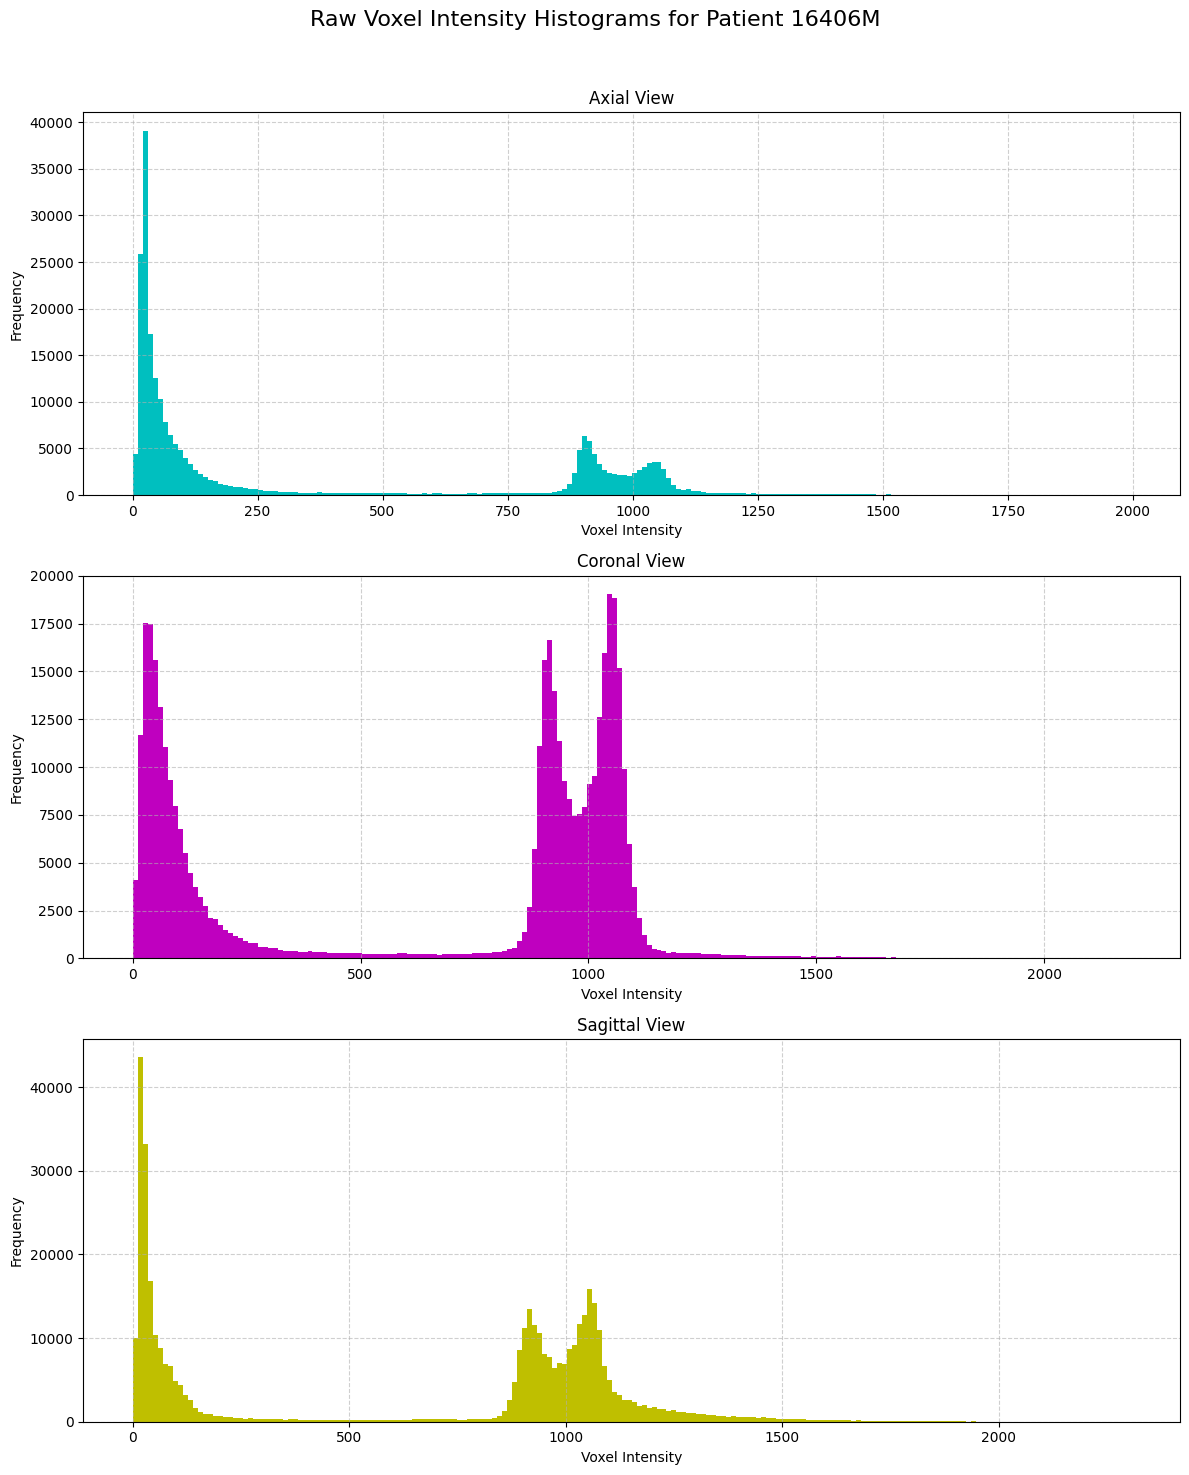

In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuration ---
RAW_DATA_ROOT = Path("/mnt/hot/public/COPDGene-1")
test_patient_id = '16406M'

# --- Load and Process Data ---
print(f"--- Analyzing Raw Voxel Histograms by View for Patient: {test_patient_id} ---")
try:
    nii_path = RAW_DATA_ROOT / f"{test_patient_id}_INSP_image.nii.gz"
    nii_img = nib.load(nii_path)
    raw_scan_3d = nii_img.get_fdata().astype(np.float32)

    # --- Get center slice indices ---
    center_x, center_y, center_z = [dim // 2 for dim in raw_scan_3d.shape]
    
    # --- Extract data for each view (only pixels > 0) ---
    axial_slice_data = raw_scan_3d[:, :, center_z].flatten()
    coronal_slice_data = raw_scan_3d[:, center_y, :].flatten()
    sagittal_slice_data = raw_scan_3d[center_x, :, :].flatten()

    axial_body = axial_slice_data[axial_slice_data > 0]
    coronal_body = coronal_slice_data[coronal_slice_data > 0]
    sagittal_body = sagittal_slice_data[sagittal_slice_data > 0]
    
    # --- Create and Plot the Histograms ---
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle(f'Raw Voxel Intensity Histograms for Patient {test_patient_id}', fontsize=16)

    axes[0].hist(axial_body, bins=200, color='c', label='Axial')
    axes[0].set_title("Axial View")
    axes[0].set_xlabel("Voxel Intensity")
    axes[0].set_ylabel("Frequency")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].hist(coronal_body, bins=200, color='m', label='Coronal')
    axes[1].set_title("Coronal View")
    axes[1].set_xlabel("Voxel Intensity")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    axes[2].hist(sagittal_body, bins=200, color='y', label='Sagittal')
    axes[2].set_title("Sagittal View")
    axes[2].set_xlabel("Voxel Intensity")
    axes[2].set_ylabel("Frequency")
    axes[2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [6]:
import nibabel as nib
from pathlib import Path

# --- Configuration ---
RAW_DATA_ROOT = Path("/mnt/hot/public/COPDGene-1")
test_patient_id = '16406M'

# --- Load the NIfTI file and check its header ---
print(f"--- Checking Header Metadata for Patient: {test_patient_id} ---")
try:
    nii_path = RAW_DATA_ROOT / f"{test_patient_id}_INSP_image.nii.gz"
    nii_img = nib.load(nii_path)

    # Attempt to access the scaling factors from the header
    print(nii_img.header)

except Exception as e:
    print(f"An error occurred: {e}")

--- Checking Header Metadata for Patient: 16406M ---
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 512 512 816   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.76171875 0.76171875 0.45       0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
q

--- Visualizing Processed Scan (3 Views) for Patient: 16406M ---

--- Verification Checks ---
Shape: (128, 128, 128)
Min value: 0.000, Max value: 1.000


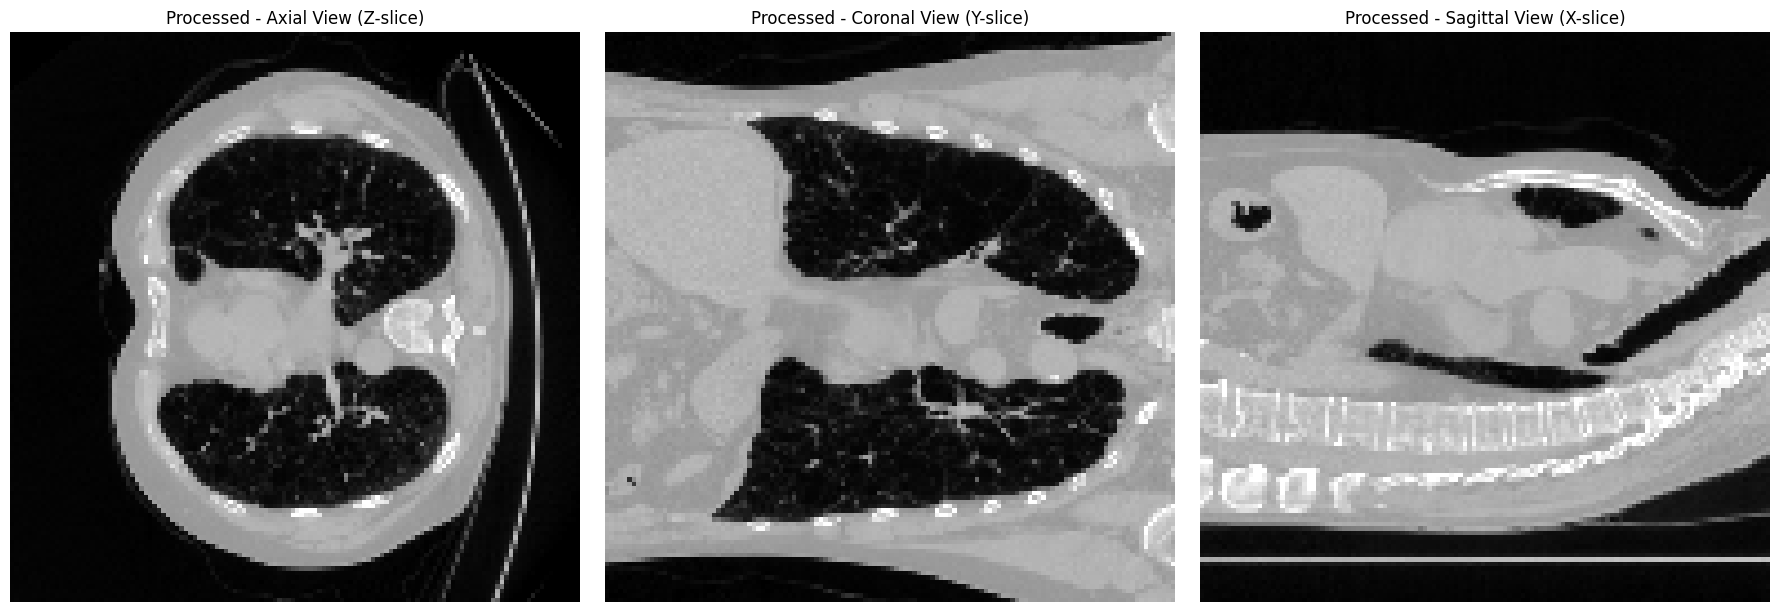

In [4]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import importlib

# --- Setup Paths and Imports ---
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Force reload the module to ensure our latest changes are used
import preprocess_data
importlib.reload(preprocess_data)
from preprocess_data import process_patient_pair

# --- Configuration ---
PROCESSED_DATA_DIR = Path("/mnt/hot/public/Akul/exhale_pred_data")
test_patient_id = '16406M'
TARGET_SHAPE = (128, 128, 128)

# --- Run Single Patient Processing ---
print(f"--- Visualizing Processed Scan (3 Views) for Patient: {test_patient_id} ---")
(PROCESSED_DATA_DIR / "inhale").mkdir(parents=True, exist_ok=True)
error = process_patient_pair(test_patient_id)

if error:
    print(f"🛑 Preprocessing Failed: {error}")
else:
    # --- Load and Visualize the Processed File ---
    try:
        processed_path = PROCESSED_DATA_DIR / "inhale" / f"{test_patient_id}.npy"
        processed_scan_3d = np.load(processed_path)

        # Verification checks
        print(f"\n--- Verification Checks ---")
        print(f"Shape: {processed_scan_3d.shape}")
        print(f"Min value: {processed_scan_3d.min():.3f}, Max value: {processed_scan_3d.max():.3f}")

        # Get center slices
        center_x, center_y, center_z = [dim // 2 for dim in processed_scan_3d.shape]

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(processed_scan_3d[:, :, center_z], cmap='gray')
        axes[0].set_title(f'Processed - Axial View (Z-slice)')
        axes[0].axis('off')

        axes[1].imshow(processed_scan_3d[:, center_y, :], cmap='gray')
        axes[1].set_title(f'Processed - Coronal View (Y-slice)')
        axes[1].axis('off')

        axes[2].imshow(processed_scan_3d[center_x, :, :], cmap='gray')
        axes[2].set_title(f'Processed - Sagittal View (X-slice)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"🛑 An error occurred during visualization: {e}")

In [1]:
import os

# --- 1. Define the paths to your processed data ---
data_dir = '/mnt/hot/public/Akul/exhale_pred_data'
inhale_dir = os.path.join(data_dir, 'inhale')
exhale_dir = os.path.join(data_dir, 'exhale')
masks_dir = os.path.join(data_dir, 'masks')

# --- 2. Get the list of all inhale scans to use as a reference ---
# We assume every patient should at least have an inhale scan.
try:
    inhale_files = set(os.listdir(inhale_dir))
    total_possible_sets = len(inhale_files)
except FileNotFoundError:
    print(f"Error: Directory not found at {inhale_dir}")
    total_possible_sets = 0

if total_possible_sets > 0:
    exhale_files = set(os.listdir(exhale_dir))
    mask_files = set(os.listdir(masks_dir))

    # --- 3. Find the complete triplets ---
    complete_sets = 0
    missing_exhale = 0
    missing_mask = 0
    
    print("--- Scanning for data integrity ---")
    for file_name in sorted(list(inhale_files)):
        has_exhale = file_name in exhale_files
        has_mask = file_name in mask_files

        if has_exhale and has_mask:
            complete_sets += 1
        else:
            if not has_exhale:
                missing_exhale += 1
                print(f"-> Missing EXHALE for: {file_name}")
            if not has_mask:
                missing_mask += 1
                print(f"-> Missing MASK for: {file_name}")

    # --- 4. Report the results ---
    print("\n--- Data Integrity Report ---")
    print(f"Total Inhale Scans Found:    {total_possible_sets}")
    print(f"Complete Triplets (i/e/m):   {complete_sets}")
    print("-" * 30)
    
    missing_total = total_possible_sets - complete_sets
    if total_possible_sets > 0:
        completeness_percentage = (complete_sets / total_possible_sets) * 100
        print(f"Missing or Incomplete Sets:  {missing_total} ({100 - completeness_percentage:.2f}%)")
        print(f"  - Missing Exhale Files:    {missing_exhale}")
        print(f"  - Missing Mask Files:      {missing_mask}")
        print(f"\nDataset Completeness: {completeness_percentage:.2f}%")
    else:
        print("No inhale files found to check against.")

--- Scanning for data integrity ---
-> Missing MASK for: 10005Q.npy
-> Missing MASK for: 10009Y.npy
-> Missing MASK for: 10010J.npy
-> Missing MASK for: 10013P.npy
-> Missing MASK for: 10017X.npy
-> Missing MASK for: 10023S.npy
-> Missing MASK for: 10028C.npy
-> Missing MASK for: 10031R.npy
-> Missing MASK for: 10032T.npy
-> Missing MASK for: 10035Z.npy
-> Missing MASK for: 10041U.npy
-> Missing MASK for: 10047G.npy
-> Missing MASK for: 10052Z.npy
-> Missing MASK for: 10055F.npy
-> Missing MASK for: 10056H.npy
-> Missing MASK for: 10057J.npy
-> Missing MASK for: 10058L.npy
-> Missing MASK for: 10060Y.npy
-> Missing MASK for: 10062C.npy
-> Missing MASK for: 10065I.npy
-> Missing MASK for: 10067M.npy
-> Missing MASK for: 10068O.npy
-> Missing MASK for: 10071D.npy
-> Missing MASK for: 10072F.npy
-> Missing MASK for: 10075L.npy
-> Missing MASK for: 10076N.npy
-> Missing MASK for: 10077P.npy
-> Missing MASK for: 10081G.npy
-> Missing MASK for: 10083K.npy
-> Missing MASK for: 10085O.npy
-> M

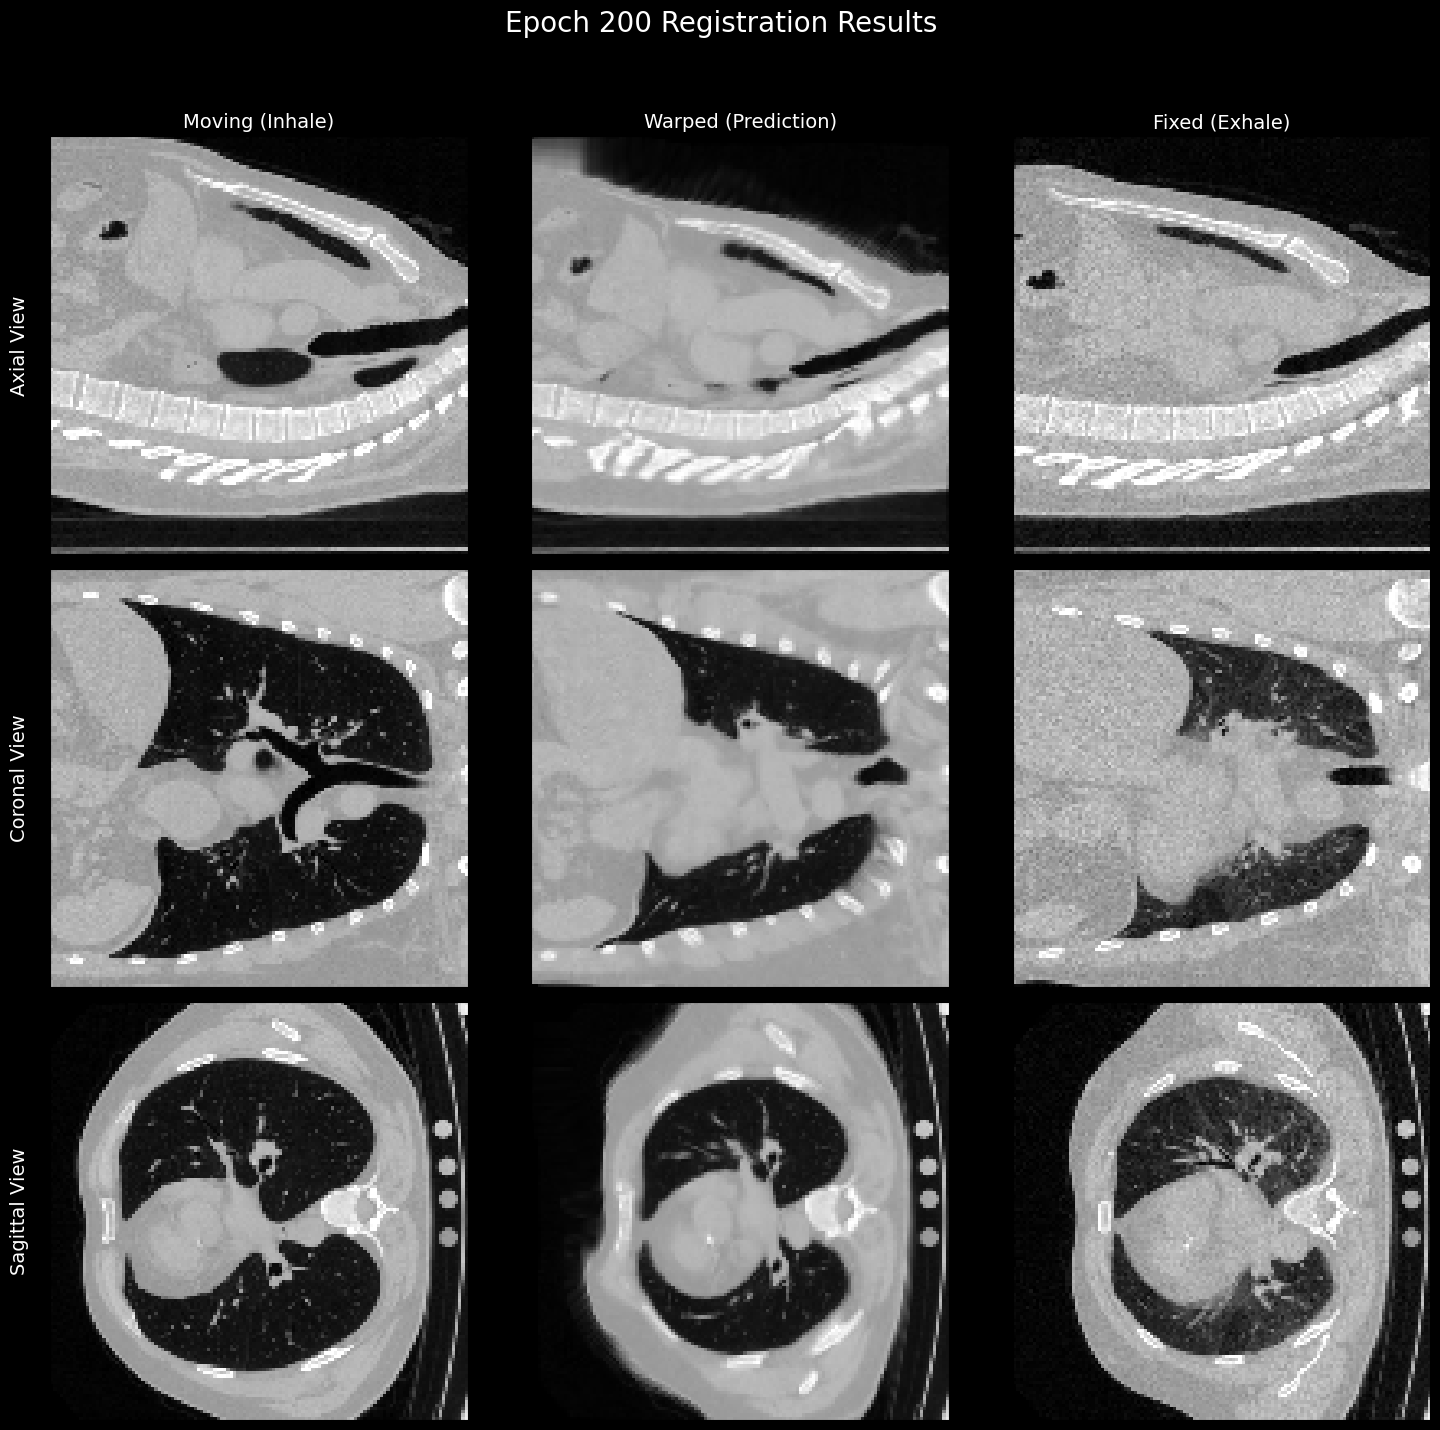

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuration ---
# Define the path to your images directory
image_dir = Path("./model_runs/ctm_run_1/images")

# Choose which epoch you want to view
epoch_to_view = 200

# --- Load the Data ---
try:
    # Construct the file paths for the chosen epoch
    moving_path = image_dir / f"epoch_{epoch_to_view}_moving.npy"
    fixed_path = image_dir / f"epoch_{epoch_to_view}_fixed_TARGET.npy"
    warped_path = image_dir / f"epoch_{epoch_to_view}_warped.npy"

    # Load the 3D numpy arrays from the files
    moving_img = np.load(moving_path)
    fixed_img = np.load(fixed_path)
    warped_img = np.load(warped_path)

    # --- Prepare Slices for Plotting ---
    # Get the center slice index for each axis
    z_slice = moving_img.shape[0] // 2
    y_slice = moving_img.shape[1] // 2
    x_slice = moving_img.shape[2] // 2

    # --- Create the 3x3 Visualization Grid ---
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), facecolor='black')
    fig.suptitle(f'Epoch {epoch_to_view} Registration Results', fontsize=20, color='white')

    # Titles for columns and rows
    cols = ['Moving (Inhale)', 'Warped (Prediction)', 'Fixed (Exhale)']
    rows = ['Axial View', 'Coronal View', 'Sagittal View']

    for ax, col in zip(axes[0], cols):
        ax.set_title(col, color='white', fontsize=14)

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, color='white', fontsize=14, rotation=90, labelpad=15)

    # Plot the images
    axes[0, 0].imshow(moving_img[z_slice, :, :], cmap='gray')
    axes[0, 1].imshow(warped_img[z_slice, :, :], cmap='gray')
    axes[0, 2].imshow(fixed_img[z_slice, :, :], cmap='gray')

    axes[1, 0].imshow(moving_img[:, y_slice, :], cmap='gray')
    axes[1, 1].imshow(warped_img[:, y_slice, :], cmap='gray')
    axes[1, 2].imshow(fixed_img[:, y_slice, :], cmap='gray')

    axes[2, 0].imshow(moving_img[:, :, x_slice], cmap='gray')
    axes[2, 1].imshow(warped_img[:, :, x_slice], cmap='gray')
    axes[2, 2].imshow(fixed_img[:, :, x_slice], cmap='gray')
    
    # Clean up axes
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find image files for epoch {epoch_to_view}.")
    print("Please make sure the epoch number is correct and the files exist in the directory.")